In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [39]:
df_rest = pd.read_csv("resturants.csv")
df_items = pd.read_csv("items.csv")
df_sales = pd.read_csv("sales.csv")

In [40]:
df_items.rename(columns={'name': 'item_name'}, inplace=True)
df_rest.rename(columns={'name': 'store_name'}, inplace=True)
# df_sales.rename(columns={'name': 'item_name'}, inplace=True) # This line caused the error as df_sales does not have a 'name' column


In [41]:
print("Sales Columns:", df_sales.columns)
print("Items Columns:", df_items.columns)
print("Restaurants Columns:", df_rest.columns)

Sales Columns: Index(['date', 'item_id', 'price', 'item_count'], dtype='object')
Items Columns: Index(['id', 'store_id', 'item_name', 'kcal', 'cost'], dtype='object')
Restaurants Columns: Index(['id', 'store_name'], dtype='object')


In [42]:
df = df_sales.merge(df_items, left_on='item_id', right_on='id', how='left') \
             .merge(df_rest, left_on="store_id", right_on="id", suffixes=('_item', '_store'))

In [43]:
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)

In [44]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter

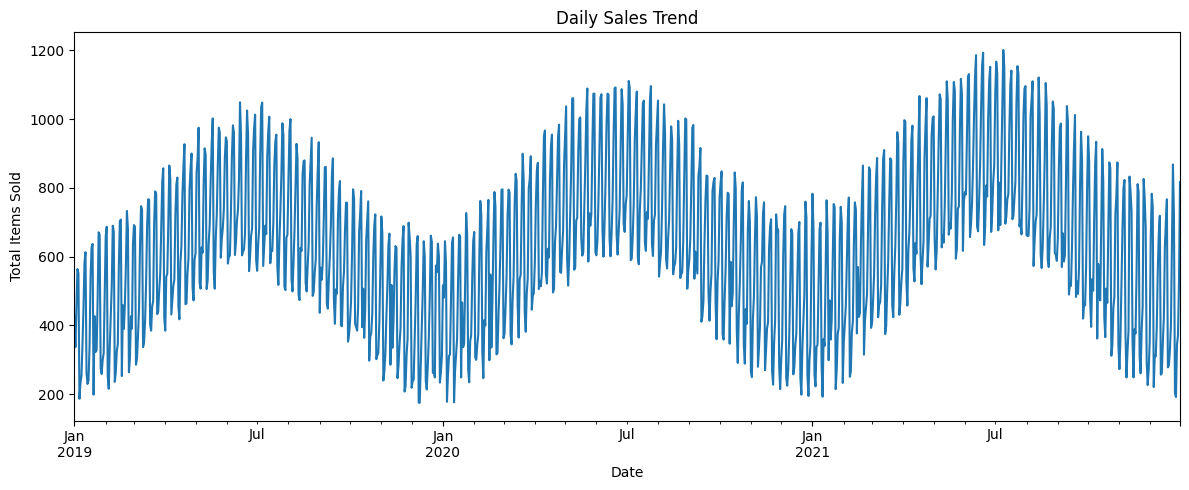

In [45]:
plt.figure(figsize=(12,5))
df.groupby('date')['item_count'].sum().plot(title="Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Items Sold")
plt.tight_layout()
plt.show()

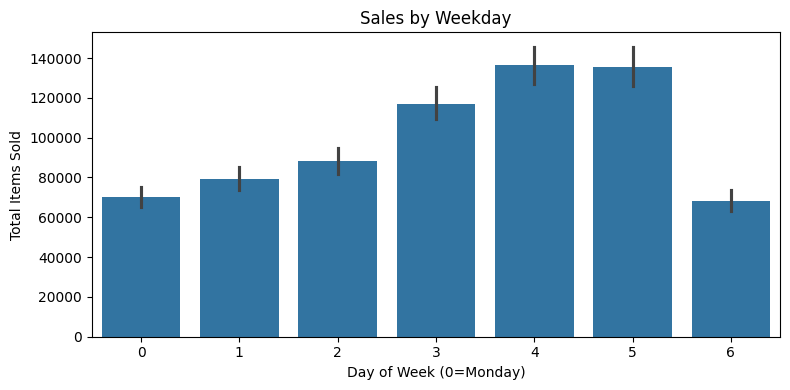

In [46]:
plt.figure(figsize=(8,4))
sns.barplot(data=df, x='weekday', y='item_count', estimator=sum)
plt.title("Sales by Weekday")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Total Items Sold")
plt.tight_layout()
plt.show()

In [47]:
top_items = df.groupby('item_name')['item_count'].sum().sort_values(ascending=False).head(10)
print("Top 10 Items Sold:\n", top_items)

Top 10 Items Sold:
 item_name
Strawberry Smoothy                 236337.0
Frozen Milky Smoothy               103263.0
Amazing pork lunch                  61043.0
Mutton Dinner                       52772.0
Orange Juice                        43874.0
Blue Ribbon Beef Entree             42774.0
Amazing Steak Dinner with Rolls     34439.0
Sweet Frozen Soft Drink             27490.0
Sea Bass with Vegetables Dinner     23839.0
Sweet Lamb Cake                     18764.0
Name: item_count, dtype: float64


In [48]:
# Most profitable store
df['revenue'] = df['item_count'] * df['price']
top_store = df.groupby('store_name')['revenue'].sum().sort_values(ascending=False)
print("Most Profitable Stores:\n", top_store)

Most Profitable Stores:
 store_name
Bob's Diner       6337275.69
Fou Cher            27885.37
Corner Cafe         16551.43
Surfs Up            15651.49
Beachfront Bar       3796.20
Sweet Shack          2578.27
Name: revenue, dtype: float64


In [49]:
# Most expensive item per store
expensive_items = df.groupby('store_name').apply(lambda x: x.sort_values('cost', ascending=False).iloc[0])
print("Most Expensive Item per Store:\n", expensive_items[['item_name', 'cost', 'kcal']])

Most Expensive Item per Store:
                                     item_name   cost  kcal
store_name                                                
Beachfront Bar          Sweet Vegi Soft Drink   5.70   538
Bob's Diner                 Sweet Fruity Cake  29.22   931
Corner Cafe                        Pike Lunch  26.37   653
Fou Cher        Blue Ribbon Fruity Vegi Lunch  53.98   881
Surfs Up                           Steak Meal  26.21   607
Sweet Shack     Blue Ribbon Frozen Milky Cake   7.70   636


/tmp/ipython-input-49-3444379855.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expensive_items = df.groupby('store_name').apply(lambda x: x.sort_values('cost', ascending=False).iloc[0])


In [50]:
# 8. Modeling and Forecasting

# Aggregate daily sales
daily_sales = df.groupby('date')['item_count'].sum().reset_index()
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['weekday'] = daily_sales['date'].dt.dayofweek
daily_sales['quarter'] = daily_sales['date'].dt.quarter

In [51]:
# Train/Test Split: Last 6 months as test
cutoff = daily_sales['date'].max() - pd.DateOffset(months=6)
train = daily_sales[daily_sales['date'] <= cutoff]
test = daily_sales[daily_sales['date'] > cutoff]

features = ['year', 'month', 'day', 'weekday', 'quarter']
X_train = train[features]
y_train = train['item_count']
X_test = test[features]
y_test = test['item_count']

In [52]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

print("\nModel Evaluation (RMSE):")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name}: RMSE = {rmse:.2f}")


Model Evaluation (RMSE):
Linear Regression: RMSE = 246.54
Random Forest: RMSE = 62.16
XGBoost: RMSE = 61.24


In [53]:
# Use best model (assume Random Forest)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [54]:
# Forecast next 365 days
future_dates = pd.date_range(start=daily_sales['date'].max() + pd.Timedelta(days=1), periods=365)
future_df = pd.DataFrame({'date': future_dates})
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day
future_df['weekday'] = future_df['date'].dt.dayofweek
future_df['quarter'] = future_df['date'].dt.quarter

In [55]:
# Predict
future_df['predicted_sales'] = best_model.predict(future_df[features])

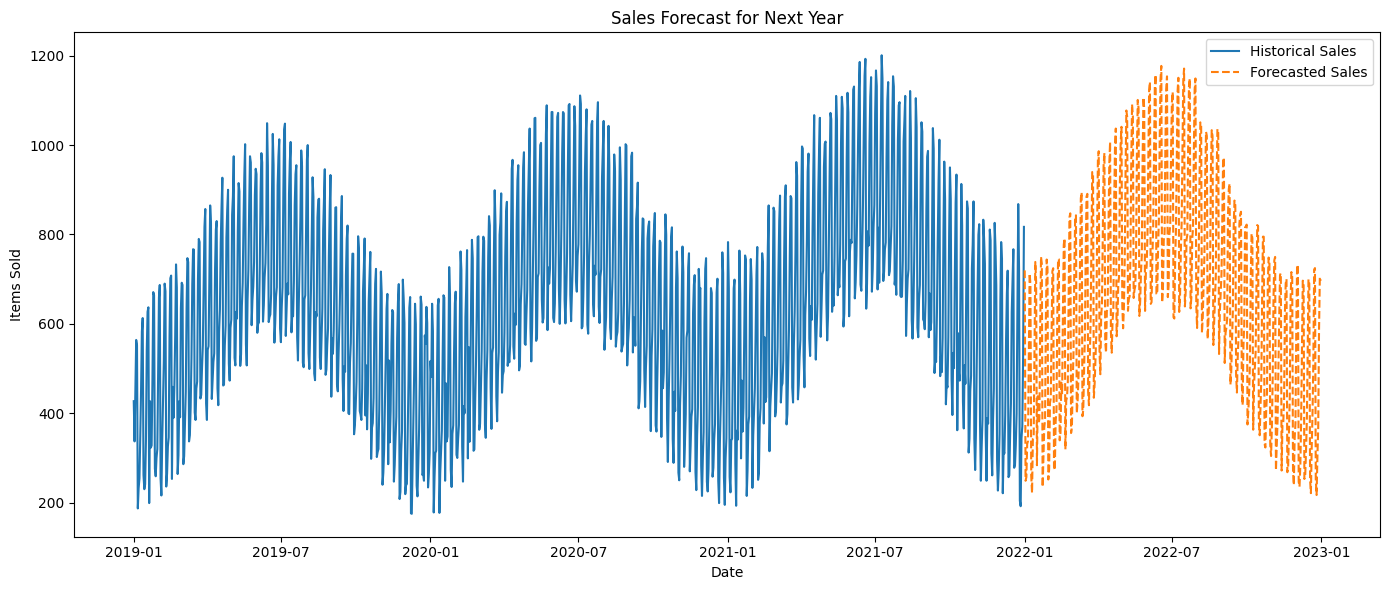

In [56]:
# Plot historical + future forecast
plt.figure(figsize=(14,6))
plt.plot(daily_sales['date'], daily_sales['item_count'], label="Historical Sales")
plt.plot(future_df['date'], future_df['predicted_sales'], label="Forecasted Sales", linestyle='--')
plt.title("Sales Forecast for Next Year")
plt.xlabel("Date")
plt.ylabel("Items Sold")
plt.legend()
plt.tight_layout()
plt.show()